This notebook evaluates the effectiveness of the gradient-based indicators on the test set.

Load the generator and classifier

In [1]:
import os
print(os.getcwd())
import torch
import numpy as np
from src_.utils import load_generator, load_facial_classifier, rank_gradient_info, perturbate_s_latents
from src_.backpropagation import generate_image_with_s_latents, backpropagation_gradients_s_space
from configs import gan_facial_ckpt_path, segmentation_facial_ckpt_path, generate_image_base_dir, sut_facial_path, preprocess_celeb_classifier
from local_models.segmentation.segmentation_handler import SegmentationModel

import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline
data_path = os.path.join(generate_image_base_dir, 'generated_images')
print(data_path, os.path.isdir(data_path))

target_logit = 15

/tmp/pycharm_project_181
/home/xchen/SMOO/generated_images False


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device ", device)
torch.manual_seed(151)
# load generator
generator = load_generator(gan_facial_ckpt_path, device)
classifier = load_facial_classifier(sut_facial_path, device)
"""if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    generator = nn.DataParallel(generator)
    classifier = nn.DataParallel(classifier)"""


device  cuda


/tmp/pycharm_project_181/src/manipulator/_style_gan_manipulator/legacy.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_lo

'if torch.cuda.device_count() > 1:\n    print(f"Using {torch.cuda.device_count()} GPUs")\n    generator = nn.DataParallel(generator)\n    classifier = nn.DataParallel(classifier)'

Load all gradient values across the population, and perturbate the channels with the highest gradients.

In [9]:
generator.mapping.w_avg

tensor([ 9.2883e-02,  4.4493e-02,  1.7580e-01, -7.5962e-02, -1.4277e-01,
         2.1576e-02, -7.7273e-02, -8.5875e-02,  1.4615e-01, -1.1361e-01,
         2.2924e-01, -3.1318e-03, -5.9554e-03,  1.1861e-01, -1.2931e-01,
         1.0087e-01, -3.2059e-03, -2.4306e-02,  9.3847e-02,  4.0706e-02,
        -6.3639e-02, -1.0107e-03, -1.1606e-01,  5.6978e-02,  2.0159e-01,
         4.7371e-01, -2.9875e-02, -3.5314e-02,  1.8939e-01, -3.1905e-02,
         9.9444e-02,  4.9196e-03,  2.4164e-01, -5.2161e-02,  1.0991e-01,
         1.8742e-01,  8.2949e-02,  4.6562e-02, -1.0943e-01,  1.8114e-01,
         1.4144e-01,  3.4908e-01, -8.0343e-03,  1.5621e-01,  3.5424e-01,
        -3.1986e-02,  1.6023e-01,  1.9629e-02,  2.5838e-01, -8.2062e-02,
         1.4445e-01,  1.0167e-01,  3.4281e-01, -5.9023e-02, -2.5277e-02,
         4.3750e-02,  8.7564e-02,  1.7740e-01, -1.7990e-01, -1.1099e-01,
         1.2395e-01,  9.4611e-02, -8.8033e-02,  5.8745e-02,  3.5248e-01,
         1.5544e-01,  1.1820e-01,  1.9804e-01, -4.1

Setting up PyTorch plugin "bias_act_plugin"... 

/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
tensor(1.4131, device='cuda:0', grad_fn=<SelectBackward0>)


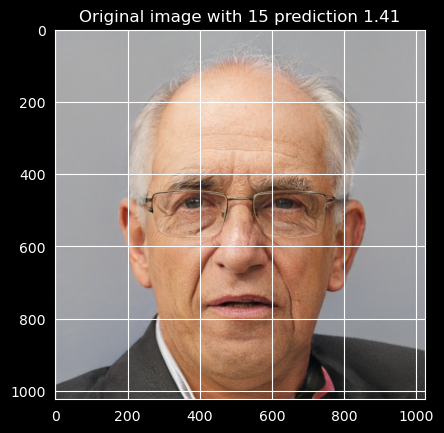

In [3]:
# generate latent vector and class label
z = torch.randn([1, generator.z_dim], device=device)

if generator.c_dim != 0:
    label = torch.zeros([1, generator.c_dim], device=device)

    target_class = 207  #  SELECT CLASS
    label[:, target_class] = 1
else:
    label = None

img_tensor = generator(z, label,
                       truncation_psi=1, noise_mode='const')# ensure deterministic and reproducible
img_tensor = (img_tensor.clamp(-1, 1) + 1) / 2  # normalize to [0, 1] ss

img = img_tensor.cpu().detach().numpy()[0]
img = img.transpose(1, 2, 0)

prediction = classifier(preprocess_celeb_classifier(img_tensor.squeeze(0)).unsqueeze(0))
print(prediction.squeeze()[target_logit])
plt.imshow(img)
plt.title(f"Original image with {target_logit} prediction {prediction.squeeze()[target_logit]:.2f}")
plt.show()


Compare the original image with the generated image with s latents

In [4]:
w = generator.mapping(z, c=label)

s_gradients, classifier_output, img_tensor = backpropagation_gradients_s_space(
    synthesis_net = generator.synthesis,
    classifier = classifier,
    preprocess= preprocess_celeb_classifier,
    w_latents= w,
    target_class= target_logit, # glasses
)

/tmp/pycharm_project_181/models/segmentation/segmentation_handler.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locat

Segmentation model loaded on cuda.


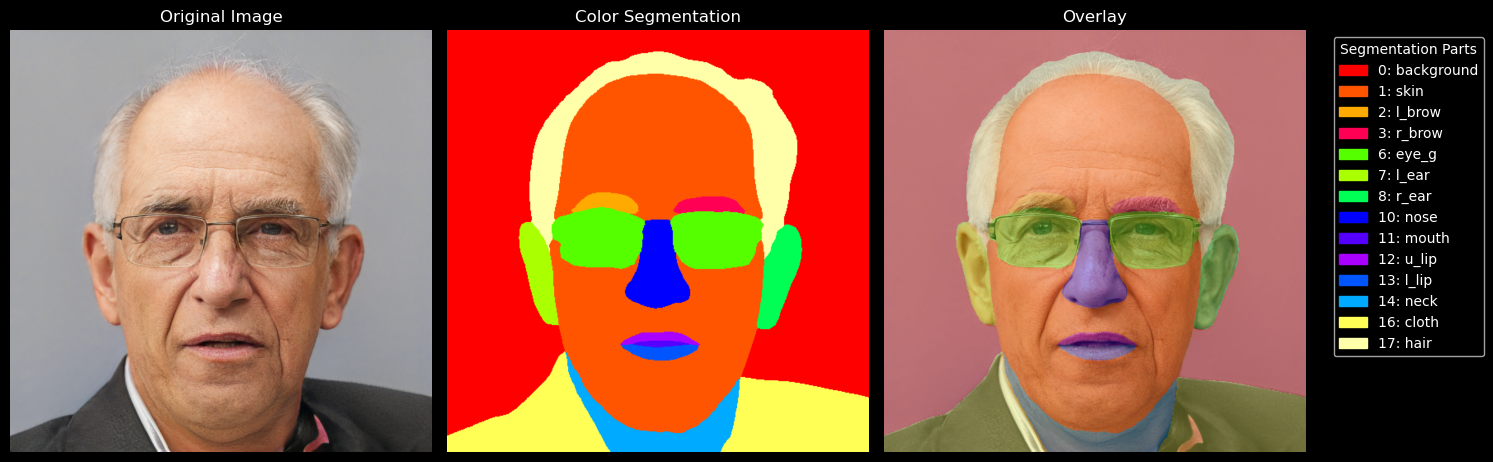

In [5]:
segmenter = SegmentationModel(segmentation_facial_ckpt_path)
# Perform segmentation
mask = segmenter.predict(img)

# Overlay mask on the original image
segmenter.visualize(img, mask)

In [6]:
ranked_gradient_info = rank_gradient_info(s_gradients)
#print(gradient_info_by_layer['input.affine'])
print(ranked_gradient_info)

{'b4.conv1.affine': {'ranked_indices': [314, 461, 169, 229, 483], 'gradients': [0.056096501648426056, 0.05524974316358566, -0.05415249615907669, -0.05291201174259186, -0.04955248534679413]}, 'b4.torgb.affine': {'ranked_indices': [152, 438, 6, 476, 262], 'gradients': [0.015024282969534397, -0.013816041871905327, 0.013278595171868801, -0.010977200232446194, -0.009892866015434265]}, 'b8.conv0.affine': {'ranked_indices': [11, 97, 347, 298, 501], 'gradients': [-0.26894333958625793, -0.1727602779865265, 0.13143420219421387, 0.0997186005115509, -0.09840850532054901]}, 'b8.conv1.affine': {'ranked_indices': [141, 398, 367, 218, 509], 'gradients': [-0.2970966100692749, 0.2801041603088379, -0.22721442580223083, -0.2073858231306076, -0.1888023465871811]}, 'b8.torgb.affine': {'ranked_indices': [214, 376, 323, 430, 275], 'gradients': [-0.024683132767677307, 0.02400011196732521, 0.02187817543745041, -0.021725505590438843, -0.02065984532237053]}, 'b16.conv0.affine': {'ranked_indices': [325, 430, 136, 

In [7]:
def compare_perturbed(s_gradients, layer_name, rank_data, prediction_target, extent_factor=40, top_n=0):
    location = rank_data['ranked_indices'][top_n]
    gradient_single = rank_data['gradients'][top_n]
    # perturbate - sign*0.1
    extent = np.sign(prediction_target)*(-extent_factor) * gradient_single
    gradient_perturbed = perturbate_s_latents(s_gradients, layer_name, location, extent)
    img_perturbed_tensor = generate_image_with_s_latents(synthesis_net = generator.synthesis,
                  s_latents = gradient_perturbed)
    img_perturbed = img_perturbed_tensor.cpu().detach().numpy()[0]
    img_perturbed = img_perturbed.transpose(1, 2, 0)

    prediction_perturbed = classifier(preprocess_celeb_classifier(img_perturbed_tensor.squeeze(0)).unsqueeze(0)).squeeze(0)
    prediction_perturbed_target = prediction_perturbed[target_logit].cpu().detach().numpy()

    confidence_drop =  np.sign(prediction_target) * (prediction_target-prediction_perturbed_target)

    return confidence_drop, img_perturbed, prediction_perturbed_target

def plot_compare_perturbed(prediction_target, img, img_perturbed, prediction_perturbed_target):
    diff_img =  np.abs(img_perturbed - img)
    region_means = segmenter.compute_region_means(diff_img, mask)
    affect_region = segmenter.part_labels[max(region_means, key=region_means.get)]
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("original")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(img_perturbed)
    plt.title("perturbed")
    plt.axis("off")

    plt.subplot(1, 3, 3)

    plt.imshow(diff_img)
    plt.title(f"{affect_region} {np.sign(prediction_target) * (prediction_target-prediction_perturbed_target):.2f}")
    plt.axis("off")
    plt.show()

def bisection_factor_adjustment(current_factor, initial_confidence,tolerance=1):
    """
    Dynamically adjust extent_factor using the bisection method to achieve misclassification
    with the adjusted confidence closest to 0.

    Args:
        current_factor (float): Initial factor value.
        initial_confidence (float): Current confidence value.
        tolerance (float): The minimum allowable difference for convergence.

    Returns:
        float: The adjusted extent_factor.
    """
    low = 1e-5  # Minimum extent_factor possible
    high = current_factor  # Start with the initial factor as the upper bound
    mid = (low + high) / 2.0  # Midpoint for bisection

    # Variables to track the best factor and closest to zero confidence
    best_factor = current_factor
    best_adjusted_confidence = float('inf')  # Start with infinity for comparison

    #low_confidence = initial_confidence
    #high_confidence = current_confidence
    while high - low > tolerance:

        # Simulate confidence adjustment based on the current midpoint factor
        confidence_drop, img_perturbed, adjusted_confidence = compare_perturbed(s_gradients, layer_name, rank_data, prediction_target, extent_factor=mid, top_n=top_n)
        #print(f"low: {low:.2f}, high: {high:.2f}, mid: {mid:.2f} , adjusted_confidence: {adjusted_confidence:.2f}, initial_confidence: {initial_confidence:.2f}")
        # Check if the confidence needs to be closer to the target
        if adjusted_confidence * initial_confidence < 0:  # Sign change = misclassification
            # Check if this confidence is closest to 0
            if abs(adjusted_confidence) < abs(best_adjusted_confidence):
                best_factor = mid
                best_adjusted_confidence = adjusted_confidence

            # Focus on the left half (reduce the high bound)
            high = mid

        else:
            low = mid  # Increase the lower bound
            #low_confidence = adjusted_confidence
        mid = (low + high) / 2.0  # Recalculate the midpoint

    return best_factor

In [8]:
top_n=0

prediction = classifier(preprocess_celeb_classifier(img_tensor.squeeze(0)).unsqueeze(0)).squeeze(0)
prediction_target = prediction[target_logit].cpu().detach().numpy()
max_confidence_drop = 0
max_confidence_drop_layer = None
for i, (layer_name, rank_data) in enumerate(ranked_gradient_info.items()):
    default_extent_factor=40
    # layer_name, rank_data = list(ranked_gradient_info.items())[0]
    if "rgb" in layer_name:
        continue
    #if layer_name != "b512.conv1.affine":
    #    continue
    confidence_drop, img_perturbed, prediction_perturbed_target = compare_perturbed(s_gradients, layer_name, rank_data, prediction_target, extent_factor=default_extent_factor, top_n=top_n)
    print(f"Layer: {layer_name}, Ranking: {top_n} confidence_drop {confidence_drop:.2f} , confidence {prediction_target:.2f} {prediction_perturbed_target:.2f}")
    if confidence_drop > max_confidence_drop:
        max_confidence_drop = confidence_drop
        max_confidence_drop_layer = layer_name

    if prediction_target * prediction_perturbed_target<0:

        adjusted_factor = bisection_factor_adjustment(default_extent_factor, prediction_target, tolerance=1)
        print(f"misclassification!! adjusted factor {adjusted_factor}")
        confidence_drop, img_perturbed, prediction_perturbed_target = compare_perturbed(s_gradients, layer_name, rank_data, prediction_target, extent_factor=adjusted_factor, top_n=top_n)
        print(f"Layer: {layer_name}, Ranking: {top_n} confidence_drop {confidence_drop:.2f} , confidence {prediction_target:.2f} {prediction_perturbed_target:.2f}")
        mask = segmenter.predict(img)
        mask_perturbed = segmenter.predict(img_perturbed)
        result = segmenter.detect_changes(img, img_perturbed, mask, mask_perturbed)
        for i in range(2):
            print(result[i]['region'] + " " + result[i]['change'],"score " + str(result[i]['composite_score']) + " " + result[i]['diff_source'])
        plot_compare_perturbed(prediction_target, img, img_perturbed, prediction_perturbed_target)

if max_confidence_drop < 0.5* np.abs(prediction_target):
    print("skip this sample")
else:
    #max_confidence_drop_layer = "b128.conv0.affine"
    confidence_drop, img_perturbed, prediction_perturbed_target= compare_perturbed(s_gradients, max_confidence_drop_layer, ranked_gradient_info[max_confidence_drop_layer], prediction_target,
                                                       extent_factor=40,
                                                        top_n=top_n)
    print(f"Layer: {max_confidence_drop_layer}_{rank_data['ranked_indices'][top_n]} confidence_drop {confidence_drop:.2f} , confidence {prediction_target:.2f} --> {prediction_perturbed_target:.2f}")

    mask = segmenter.predict(img)
    mask_perturbed = segmenter.predict(img_perturbed)
    result = segmenter.detect_changes(img, img_perturbed, mask, mask_perturbed)
    for i in range(2):
        print(result[i]['region'] + " " + result[i]['change'],"score " + str(result[i]['composite_score']) + " " + result[i]['diff_source'])
    plot_compare_perturbed(prediction_target, img, img_perturbed, prediction_perturbed_target)
    #break

Layer: b4.conv1.affine, Ranking: 0 confidence_drop -0.53 , confidence 1.09 1.63
Layer: b8.conv0.affine, Ranking: 0 confidence_drop 0.65 , confidence 1.09 0.44
Layer: b8.conv1.affine, Ranking: 0 confidence_drop 0.51 , confidence 1.09 0.58
Layer: b16.conv0.affine, Ranking: 0 confidence_drop 6.79 , confidence 1.09 -5.70
misclassification!! adjusted factor 28.7500028125
Layer: b16.conv0.affine, Ranking: 0 confidence_drop 1.23 , confidence 1.09 -0.14


KeyError: 'diff_source'

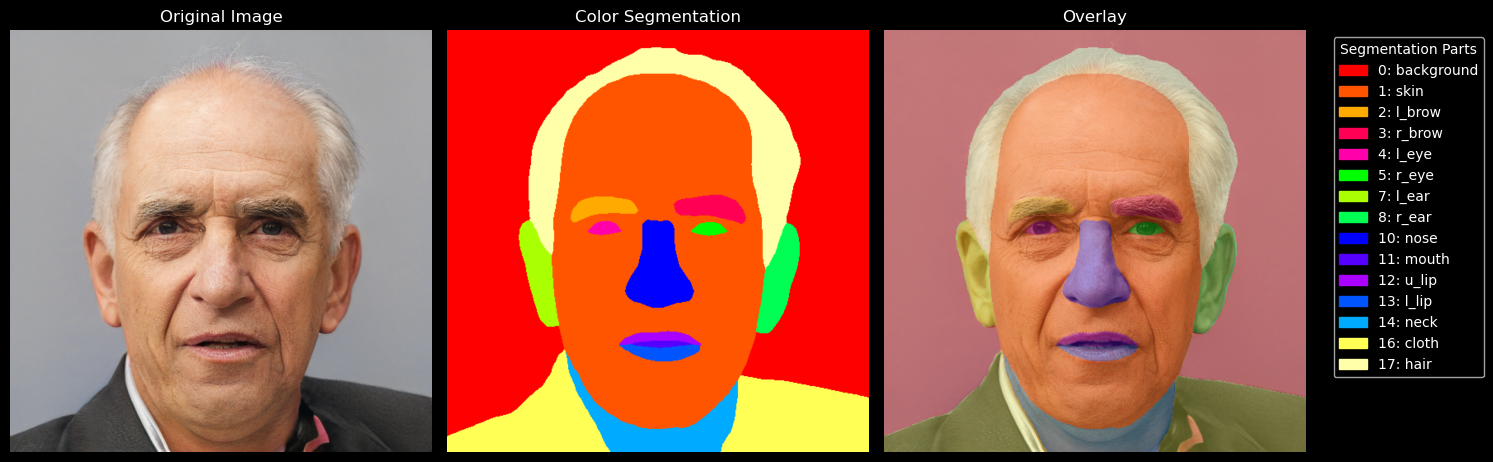

In [9]:
segmenter.visualize(img_perturbed, mask_perturbed)

In [10]:
result

[{'region': 'glasses',
  'change': 'removed',
  'iou_diff': 1.0,
  'l1': 0.1,
  'hue_shift': 0.39,
  'ssim_diff': 0.49,
  'composite_score': 0.5523,
  'diff_source': 'iou_diff'},
 {'region': 'eyes',
  'change': 'added',
  'iou_diff': 1.0,
  'l1': 0.07,
  'hue_shift': 0.32,
  'ssim_diff': 0.17,
  'composite_score': 0.4143,
  'diff_source': 'iou_diff'},
 {'region': 'eyebrows',
  'change': 'deformatted',
  'iou_diff': 0.39,
  'l1': 0.11,
  'hue_shift': 0.59,
  'ssim_diff': 0.37,
  'composite_score': 0.3442,
  'diff_source': 'hue_shift'},
 {'region': 'skin',
  'change': 'maintained',
  'iou_diff': 0.17,
  'l1': 0.04,
  'hue_shift': 0.29,
  'ssim_diff': 0.32,
  'composite_score': 0.2146,
  'diff_source': 'ssim_diff'},
 {'region': 'nose',
  'change': 'maintained',
  'iou_diff': 0.08,
  'l1': 0.07,
  'hue_shift': 0.51,
  'ssim_diff': 0.31,
  'composite_score': 0.2102,
  'diff_source': 'hue_shift'},
 {'region': 'mouth',
  'change': 'maintained',
  'iou_diff': 0.09,
  'l1': 0.05,
  'hue_shift':